In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, LayerNormalization
from keras.optimizers import Adam, SGD
import keras.backend as K
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import sklearn.linear_model
import sklearn.preprocessing
import statistics

In [2]:
def MeanPositiveError(truth, prediction):
    error = truth - prediction
    error = error[error >= 0]
    return np.sum(error)/np.shape(truth)[0]

def keras_mpe(y_true, y_pred):
    error = (y_true - y_pred)
    positive_error = K.sum(error[K.greater_equal(error, 0)])
    negative_error = K.sum(K.sqrt(K.abs(error[K.greater_equal(0.0, error)])))
    
    return 2 * positive_error + negative_error

## Zip Predictor

In [3]:
# Import decompression size .csv
zip_results_df = pd.read_csv("../data/zip_decompression_results.csv")

x = np.array(zip_results_df.compressed_size)
y = np.array(zip_results_df.decompressed_size)

In [4]:
# Train sklearn model
zip_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=False)
zip_sklearn_model.fit(x.reshape(-1, 1), y)

y_pred = zip_sklearn_model.predict(x.reshape(-1, 1))

print(f"Line: {zip_sklearn_model.coef_}x + {zip_sklearn_model.intercept_}")
print(f"R^2: {zip_sklearn_model.score(x.reshape(-1, 1), y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(y, y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(y, y_pred))}")
print(f"MPE: {MeanPositiveError(y, y_pred)}")

Line: [5.85125935]x + 0.0
R^2: 0.4113125630593395
MSE: 1.3314849911372577e+18
RMSE: 1153899905.1639001
MPE: 109879416.00334726


In [5]:
error = y_pred - y
np.quantile(error, 0.95)

668651146.3711116

In [6]:
# Train keras model

x_sc = sklearn.preprocessing.StandardScaler()
y_sc = sklearn.preprocessing.StandardScaler()
x_scaled = x_sc.fit_transform(x.reshape(-1, 1)).flatten()
y_scaled = y_sc.fit_transform(y.reshape(-1, 1)).flatten()

adam = Adam(lr=0.01)
sgd = SGD(lr=0.01)

zip_keras_model = Sequential()
zip_keras_model.add(Input((1,)))
zip_keras_model.add(Dense(1, activation="linear", use_bias=False))
zip_keras_model.compile(optimizer=sgd, loss=keras_mpe)

zip_keras_model.summary()

history = zip_keras_model.fit(x_scaled, y_scaled,
                              epochs=100)

y_pred = y_sc.inverse_transform(zip_keras_model.predict(x_scaled).reshape(-1, 1)).flatten()

print(f"MSE: {sklearn.metrics.mean_squared_error(y, y_pred) / (10 ** 9)}GB")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(y, y_pred)) / (10 ** 9)}GB")
print(f"MPE: {MeanPositiveError(y, y_pred) / (10 ** 9)}GB")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
53/53 [==============================] - 1s 741us/step - loss: 13.8078
Epoch 2/100
53/53 [==============================] - 0s 867us/step - loss: 10.4909
Epoch 3/100
53/53 [==============================] - 0s 888us/step - loss: 9.7051
Epoch 4/100
53/53 [==============================] - 0s 943us/step - loss: 13.5043
Epoch 5/100
53/53 [==============================] - 0s 879us/step - loss: 30.4849
Epoch 6/100
53/53 [==============================] - 0s 744us/step - loss: 11.2612
Epoch 7/100
53/53 [==============================] - 0s 793us/step - loss: 10.3593
Epoch 8/100
53/53 [==============================] - 0s 897us/step - loss: 1

53/53 [==============================] - 0s 642us/step - loss: 9.3829
Epoch 94/100
53/53 [==============================] - 0s 676us/step - loss: 10.8400
Epoch 95/100
53/53 [==============================] - 0s 534us/step - loss: 11.2574
Epoch 96/100
53/53 [==============================] - 0s 741us/step - loss: 11.1974
Epoch 97/100
53/53 [==============================] - 0s 741us/step - loss: 10.3113
Epoch 98/100
53/53 [==============================] - 0s 820us/step - loss: 11.2735
Epoch 99/100
53/53 [==============================] - 0s 645us/step - loss: 12.5257
Epoch 100/100
53/53 [==============================] - 0s 600us/step - loss: 10.2552
MSE: 1371034016.5691843GB
RMSE: 1.1709116177445607GB
MPE: 0.15251121428156567GB


In [7]:
def zip_keras_predict(x):
    x_scaled = x_sc.transform(x)
    return y_sc.inverse_transform(zip_keras_model.predict(x_scaled).reshape(-1, 1)).flatten()

Text(0, 0.5, 'Decompressed size (bytes)')

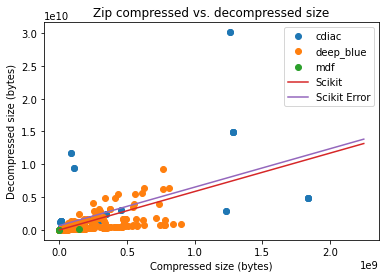

In [8]:
# Visualize compression vs. decompression
x1 = zip_results_df.compressed_size
y1 = zip_results_df.decompressed_size

# Figure 1
for name, group in zip_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
         zip_sklearn_model.predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
         label="Scikit")

plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
         zip_sklearn_model.predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)) + 668651146.3711116, 
         label="Scikit Error")

# plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
#          zip_keras_predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
#          label="Keras")

plt.legend()
plt.title("Zip compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

## Gzip Predictor

In [78]:
def categorize(x):
    categories = []
    
    for i in x:
        if i == 0:
            categories.append(0)
        else:
            categories.append(int(np.floor(np.log10(i))))
            
    return categories

In [91]:
# Import decompression size .csv
gzip_results_df = pd.read_csv("../data/gzip_decompression_results.csv")
gzip_results_df["size_bin"] = categorize(list(gzip_results_df.compressed_size))

one_hot = pd.get_dummies(gzip_results_df.size_bin)
# Drop column B as it is now encoded
gzip_results_df = gzip_results_df.drop("size_bin",axis = 1)
# Join the encoded df
gzip_results_df = gzip_results_df.join(one_hot)
# print(gzip_results_df.compressed_size.to_frame().join(one_hot))

gzip_x = np.array(gzip_results_df.compressed_size.to_frame().join(one_hot))
gzip_y = np.array(gzip_results_df.decompressed_size)
print(gzip_x)

[[     18068          0          0 ...          0          0          0]
 [1388469496          0          0 ...          0          0          1]
 [    241217          0          0 ...          0          0          0]
 ...
 [ 164545364          0          0 ...          0          1          0]
 [   5013398          0          0 ...          0          0          0]
 [   2299727          0          0 ...          0          0          0]]


In [83]:
# Train sklearn model
gzip_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=True)
gzip_sklearn_model.fit(gzip_x, gzip_y)

gzip_y_pred = gzip_sklearn_model.predict(gzip_x)

print(f"Line: {gzip_sklearn_model.coef_}x + {gzip_sklearn_model.intercept_}")
print(f"R^2: {gzip_sklearn_model.score(gzip_x, gzip_y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(gzip_y, gzip_y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(gzip_y, gzip_y_pred))}")
print(f"MPE: {MeanPositiveError(gzip_y, gzip_y_pred)}")

Line: [ 3.05442131e+00  1.05000223e+08  1.05000140e+08  1.05101813e+08
  1.10707434e+08  1.29033331e+08  1.13065477e+08  1.91163223e+08
  2.08379487e+08 -1.06745113e+09]x + -105000222.84613381
R^2: 0.859502285325393
MSE: 3.9993631312305224e+16
RMSE: 199984077.64695975
MPE: 21648710.114336543


In [123]:
# Import decompression size .csv
gzip_results_df = pd.read_csv("../data/gzip_decompression_results.csv")
gzip_results_df = gzip_results_df[gzip_results_df.compressed_size > 0]
gzip_results_df = gzip_results_df[gzip_results_df.decompressed_size > 0]

gzip_x = np.array(gzip_results_df.compressed_size)
gzip_y = np.array(gzip_results_df.decompressed_size)

In [124]:
# Train sklearn model
gzip_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=True)
gzip_sklearn_model.fit(gzip_x.reshape(-1, 1), gzip_y)

gzip_y_pred = gzip_sklearn_model.predict(gzip_x.reshape(-1, 1))

print(f"Line: {gzip_sklearn_model.coef_}x + {gzip_sklearn_model.intercept_}")
print(f"R^2: {gzip_sklearn_model.score(gzip_x.reshape(-1, 1), gzip_y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(gzip_y, gzip_y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(gzip_y, gzip_y_pred))}")
print(f"MPE: {MeanPositiveError(gzip_y, gzip_y_pred)}")

Line: [2.74734219]x + 21742394.33076863
R^2: 0.848886566684574
MSE: 4.3599387444476296e+16
RMSE: 208804663.36860463
MPE: 25645869.28820099


In [125]:
import random
gzip_error = gzip_y_pred - gzip_y
N = 10000
num_samples = len(error) // 2
means = []
num_negatives = []
median = []

for i in range(N):
    samples = random.choices(gzip_error, k=num_samples)
    means.append(np.mean(samples))
    median.append(np.percentile(samples, 50))
    num_negatives.append(len([x for x in samples if x < 0]))

means.sort()
num_negatives.sort()
median.sort()

print("Means")
print(np.mean(means))
print(np.percentile(means, 1))
print(np.percentile(means, 99))
print("Num negatives")
print(np.mean(num_negatives))
print(np.percentile(num_negatives, 2.5))
print(np.percentile(num_negatives, 97.5))
print("Medians")
print(np.mean(median))
print(np.percentile(median, 2.5))
print(np.percentile(median, 97.5))

Means
74147.17277909699
-17473621.305023972
17249974.025042515
Num negatives
125.4527
106.0
146.0
Medians
19452074.502140425
19447267.01982867
19458174.134892076


[0.12551615]


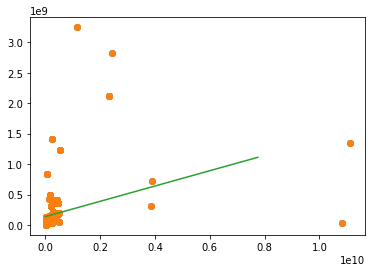

In [311]:
X = abs(gzip_y_pred[gzip_error < 0])
Y = abs(gzip_error[gzip_error < 0])

plt.plot(X, Y, marker="o", linestyle="")
# plt.yscale("log")
# plt.xscale("log")

gzip_results_df = pd.read_csv("../data/gzip_decompression_results.csv")
gzip_results_df = gzip_results_df[gzip_results_df.compressed_size > 0]

X = gzip_y_pred
Y = gzip_error
X = X[Y < 0]
Y = Y[Y < 0]
X = abs(X)
Y = abs(Y)
# X = np.log10(zip_x)
# Y = np.log10(zip_y)

plt.plot(X, Y, marker="o", linestyle="")

# # Train sklearn model
gzip_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=True)
gzip_sklearn_model.fit(X.reshape(-1,1), Y)

print(gzip_sklearn_model.coef_)

plt.plot(np.array([i for i in range(1, 8*10**9, 25*10**7)]), 
         gzip_sklearn_model.predict(np.array([i for i in range(1, 8*10**9, 25*10**7)]).reshape(-1, 1)))

# tar_y_pred = tar_sklearn_model.predict(tar_x.reshape(-1, 1))


# model = sklearn.linear_model.LinearRegression(fit_intercept=True)
# model.fit(np.log10(gzip_x).reshape(-1,1), np.log10(gzip_y))
# print(f"Line: {model.coef_}x + {model.intercept_}")

Text(0, 0.5, 'Decompressed size (bytes)')

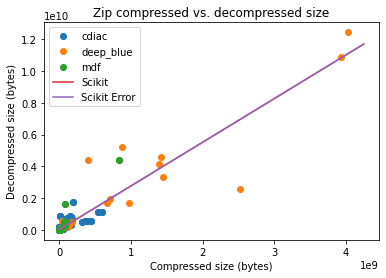

In [13]:
# Visualize compression vs. decompression
x1 = gzip_results_df.compressed_size
y1 = gzip_results_df.decompressed_size

# Figure 1
for name, group in gzip_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

plt.plot(np.array([i for i in range(1, 45*10**8, 25*10**7)]), 
         gzip_sklearn_model.predict(np.array([i for i in range(1, 45*10**8, 25*10**7)]).reshape(-1, 1)), 
         label="Scikit")

plt.plot(np.array([i for i in range(1, 45*10**8, 25*10**7)]), 
         gzip_sklearn_model.predict(np.array([i for i in range(1, 45*10**8, 25*10**7)]).reshape(-1, 1)) + 7038058.413954257, 
         label="Scikit Error")

# plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
#          zip_keras_predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
#          label="Keras")

plt.legend()
plt.title("Zip compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

## Tar Predictor

In [14]:
# Import decompression size .csv
tar_results_df = pd.read_csv("../data/tar_decompression_results.csv")

tar_x = np.array(tar_results_df.compressed_size)
tar_y = np.array(tar_results_df.decompressed_size)

In [15]:
# Train sklearn model
tar_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=False)
tar_sklearn_model.fit(tar_x.reshape(-1, 1), tar_y)

tar_y_pred = tar_sklearn_model.predict(tar_x.reshape(-1, 1))

print(f"Line: {tar_sklearn_model.coef_}x + {tar_sklearn_model.intercept_}")
print(f"R^2: {tar_sklearn_model.score(tar_x.reshape(-1, 1), tar_y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(tar_y, tar_y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(tar_y, tar_y_pred))}")
print(f"MPE: {MeanPositiveError(tar_y, tar_y_pred)}")

Line: [3.1911584]x + 0.0
R^2: 0.9762367912424945
MSE: 6.551587325313838e+17
RMSE: 809418762.1567614
MPE: 55223946.37318251


In [16]:
import random
tar_error = tar_y_pred - tar_y
N = 10000
num_samples = len(tar_error) // 2
means = []
num_negatives = []
median = []

for i in range(N):
    samples = random.choices(tar_error, k=num_samples)
    means.append(np.mean(samples))
    median.append(np.percentile(samples, 50))
    num_negatives.append(len([x for x in samples if x < 0]))

means.sort()
num_negatives.sort()
median.sort()

print("Means")
print(np.mean(means))
print(np.percentile(means, 1))
print(np.percentile(means, 99))
print("Num negatives")
print(np.mean(num_negatives))
print(np.percentile(num_negatives, 2.5))
print(np.percentile(num_negatives, 97.5))
print("Medians")
print(np.mean(median))
print(np.percentile(median, 2.5))
print(np.percentile(median, 97.5))

Means
121286603.55367503
-3742789.8592936704
279837777.4806468
Num negatives
98.2423
85.0
111.0
Medians
-521387.2946276739
-3299128.99821971
114375.84805946633


Line: [3.20199824]x + -124141932.93558025
R^2: 0.9767843422534486
MSE: 6.400625883198153e+17
RMSE: 800039116.7435598
MPE: 152182143.0292565


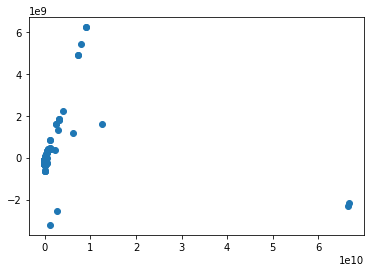

[0.03512739]


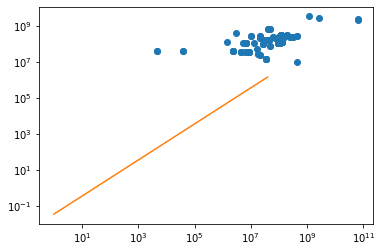

In [303]:
tar_results_df = pd.read_csv("../data/tar_decompression_results.csv")
# tar_results_df = tar_results_df[tar_results_df.compressed_size < (10 ** 10)]

tar_x = np.array(tar_results_df.compressed_size)
tar_y = np.array(tar_results_df.decompressed_size)

# Train sklearn model
tar_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=True)
tar_sklearn_model.fit(tar_x.reshape(-1, 1), tar_y)

tar_y_pred = tar_sklearn_model.predict(tar_x.reshape(-1, 1))

print(f"Line: {tar_sklearn_model.coef_}x + {tar_sklearn_model.intercept_}")
print(f"R^2: {tar_sklearn_model.score(tar_x.reshape(-1, 1), tar_y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(tar_y, tar_y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(tar_y, tar_y_pred))}")
print(f"MPE: {MeanPositiveError(tar_y, tar_y_pred)}")

tar_error = tar_y_pred - tar_y


plt.plot(tar_y_pred, tar_error, marker="o", linestyle="")
# plt.yscale("log")
# plt.xscale("log")

plt.show()

tar_results_df = pd.read_csv("../data/tar_decompression_results.csv")
tar_results_df = tar_results_df[tar_results_df.compressed_size > 0]

X = tar_y_pred
Y = tar_error
X = abs(X[Y < 0])
Y = abs(Y[Y < 0])
# X = np.log10(X)
# Y = np.log10(Y)

# Train sklearn model
tar_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=False)
tar_sklearn_model.fit(X.reshape(-1,1), Y)

print(tar_sklearn_model.coef_)

plt.plot(X, Y, marker="o", linestyle="")

plt.plot(np.array([i for i in range(1, 40*10**6, 5*10**5)]), 
         tar_sklearn_model.predict(np.array([i for i in range(1, 40*10**6, 5*10**5)]).reshape(-1, 1)), 
         label="Scikit")

plt.yscale("log")
plt.xscale("log")

plt.show()

# Line: [1.65284959]x + 40853328.34755623

Text(0, 0.5, 'Decompressed size (bytes)')

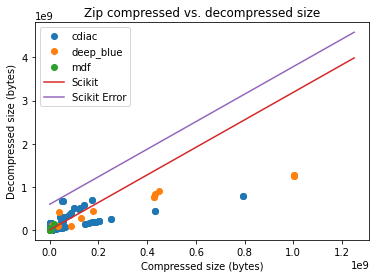

In [17]:
# Visualize compression vs. decompression
tar_results_df = tar_results_df[tar_results_df.decompressed_size < 1.5*10**9]

x1 = tar_results_df.compressed_size
y1 = tar_results_df.decompressed_size

# Figure 1
for name, group in tar_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

plt.plot(np.array([i for i in range(1, 15*10**8, 25*10**7)]), 
         tar_sklearn_model.predict(np.array([i for i in range(1, 15*10**8, 25*10**7)]).reshape(-1, 1)), 
         label="Scikit")

plt.plot(np.array([i for i in range(1, 15*10**8, 25*10**7)]), 
         tar_sklearn_model.predict(np.array([i for i in range(1, 15*10**8, 25*10**7)]).reshape(-1, 1)) + 595931136.9222465, 
         label="Scikit Error")

# plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
#          zip_keras_predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
#          label="Keras")

plt.legend()
plt.title("Zip compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

## Zip Predictor

In [320]:
# Import decompression size .csv
zip_results_df = pd.read_csv("../data/zip_decompression_results.csv")
zip_results_df = zip_results_df[zip_results_df.compressed_size > 0]
zip_resutls_df = zip_results_df[zip_results_df.decompressed_size > 0]

zip_x = np.array(zip_results_df.compressed_size)
zip_y = np.array(zip_results_df.decompressed_size)

In [323]:
# Train sklearn model
zip_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=False)
zip_sklearn_model.fit(zip_x.reshape(-1, 1), zip_y)

zip_y_pred = zip_sklearn_model.predict(zip_x.reshape(-1, 1))
zip_error = zip_y_pred - zip_y

print(zip_y_pred[0])
print(zip_error[0])

print(f"Line: {zip_sklearn_model.coef_}x + {zip_sklearn_model.intercept_}")
print(f"R^2: {zip_sklearn_model.score(zip_x.reshape(-1, 1), zip_y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(zip_y, zip_y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(zip_y, zip_y_pred))}")
print(f"MPE: {MeanPositiveError(zip_y, zip_y_pred)}")

1699163698.3995402
-1548694953.6004598
Line: [5.85125935]x + 0.0
R^2: 0.4113125630593395
MSE: 1.3314849911372577e+18
RMSE: 1153899905.1639001
MPE: 109879416.00334726


In [278]:
import random
zip_error = zip_y_pred - zip_y
N = 10000
num_samples = len(zip_error) // 2
means = []
median = []
num_negatives = []

for i in range(N):
    samples = random.choices(zip_error, k=num_samples)
    means.append(np.mean(samples))
    median.append(np.percentile(samples, 50))
    num_negatives.append(len([x for x in samples if x < 0]))

means.sort()
num_negatives.sort()
median.sort()

print("Means")
print(np.mean(means))
print(np.percentile(means, 1))
print(np.percentile(means, 99))
print("Num negatives")
print(np.mean(num_negatives))
print(np.percentile(num_negatives, 2.5))
print(np.percentile(num_negatives, 97.5))
print("Medians")
print(np.mean(median))
print(np.percentile(median, 2.5))
print(np.percentile(median, 97.5))

Means
19657884.172665697
-82090664.3447527
100957393.57850997
Num negatives
245.7576
220.0
272.0
Medians
548385.5267704739
502194.41432006215
645485.7941079487


In [279]:
import random
N = 10000
num_samples = len(zip_x) // 2
stdev = []

for i in range(N):
    samples = random.choices(zip_x, k=num_samples)
    stdev.append(np.std(samples))

stdev.sort()

print(np.percentile(stdev, 50))
print(np.percentile(stdev, 1))
print(np.percentile(stdev, 99))

162258830.37961394
117075595.39381948
211286626.4903643


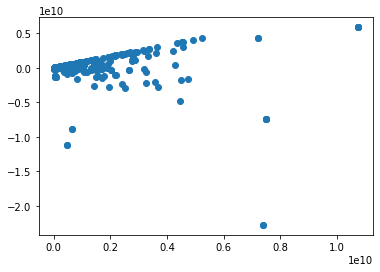

1699163698.3995402
-1548694953.6004598
[1.25709441]


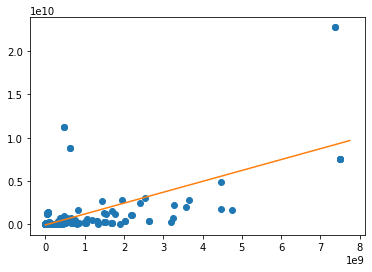

In [325]:
plt.plot(zip_y_pred, zip_error, marker="o", linestyle="")
# plt.yscale("log")
# plt.xscale("log")

# plt.plot(np.array([i for i in range(1, 20*10**8, 25*10**7)]), 
#          zip_sklearn_model.predict(np.array([i for i in range(1, 20*10**8, 25*10**7)]).reshape(-1, 1)), 
#          label="Scikit")

plt.show()

# plt.yscale("log")
# plt.xscale("log")

zip_results_df = pd.read_csv("../data/zip_decompression_results.csv")
zip_results_df = zip_results_df[zip_results_df.compressed_size > 0]

X = zip_y_pred
Y = zip_error
print(X[0])
print(Y[0])
X = X[Y < 0]
Y = Y[Y < 0]

X = abs(X)
Y = abs(Y)
# X = np.log10(zip_x)
# Y = np.log10(zip_y)

plt.plot(X, Y, marker="o", linestyle="")

# # Train sklearn model
zip_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=True)
zip_sklearn_model.fit(X.reshape(-1,1), Y)

print(zip_sklearn_model.coef_)

plt.plot(np.array([i for i in range(1, 8*10**9, 25*10**7)]), 
         zip_sklearn_model.predict(np.array([i for i in range(1, 8*10**9, 25*10**7)]).reshape(-1, 1)))

# tar_y_pred = tar_sklearn_model.predict(tar_x.reshape(-1, 1))